# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
from importlib import reload
import utils
import simulate

reload(utils)
reload(simulate)

# now you can call your updated function
from simulate import backtest_strategy
from utils import plot_strategy_overview_multi
from utils import plot_strategy_overview



# Load data

In [25]:
df = pd.read_csv("BTCUSDT_price_data_2024-01-24-2.csv")
df["timestamp"] = df["timestamp"].astype(str).str.replace(r"[^0-9]", "", regex=True)
df["timestamp"] = df["timestamp"].astype(float) / 1000
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
df = df.set_index("datetime")
df.head()

,timestamp,mid_price,volume
datetime,,,
2024-01-24 00:00:00,1.706054e+09,39881.95,439.561
2024-01-24 00:01:00,1.706054e+09,39926.55,776.492
2024-01-24 00:02:00,1.706055e+09,39877.05,339.306
2024-01-24 00:03:00,1.706055e+09,39927.45,246.511
2024-01-24 00:04:00,1.706055e+09,39926.55,423.920


## Task 1

In [26]:
df["p_t_minus_1"] = df["mid_price"].shift(1)
df["asset_return"] = ((df["mid_price"] - df["p_t_minus_1"]) / df["p_t_minus_1"]).fillna(0.0)

## Task 2

In [27]:
window = 10
df["sma"] = df["mid_price"].rolling(window=window).mean()

In [ ]:
## Move to a separate function
# df = simulate.compute_sma_signal(df, window=10)

## Task 3

In [29]:
df["signal"] = 0
df.loc[df["mid_price"] > df["sma"], "signal"] = 1
df.loc[df["mid_price"] < df["sma"], "signal"] = -1

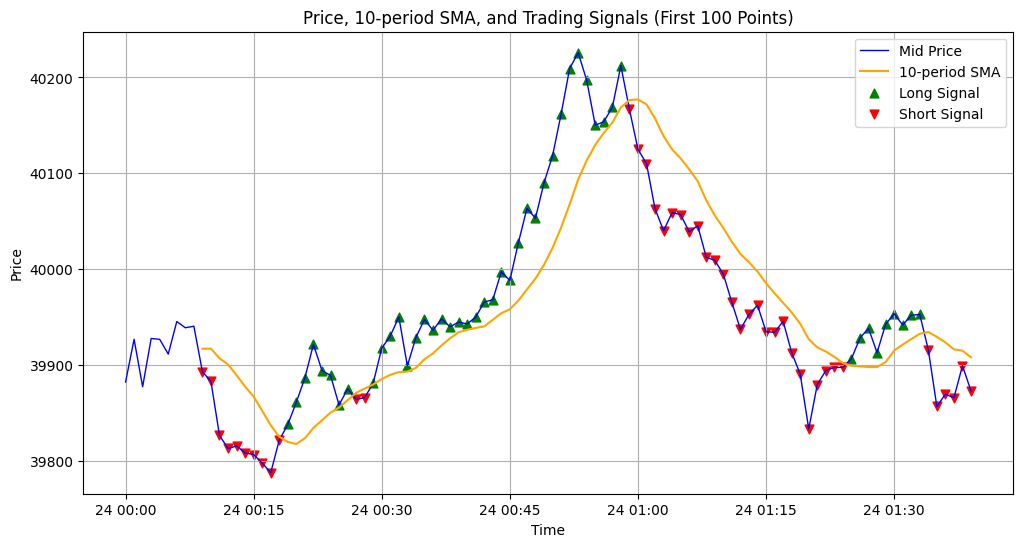

In [30]:
# --- Plot: Price, SMA, and Trading Signals (first 100 points) ---

subset = df.iloc[:100]

plt.figure(figsize=(12, 6))

plt.plot(subset.index, subset["mid_price"], label="Mid Price", color="blue", linewidth=1)
plt.plot(subset.index, subset["sma"], label="10-period SMA", color="orange", linewidth=1.5)

# Mark long and short signals
long_signals = subset[subset["signal"] == 1]
short_signals = subset[subset["signal"] == -1]

plt.scatter(long_signals.index, long_signals["mid_price"], label="Long Signal", color="green", marker="^", s=40)
plt.scatter(short_signals.index, short_signals["mid_price"], label="Short Signal", color="red", marker="v", s=40)

plt.title("Price, 10-period SMA, and Trading Signals (First 100 Points)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

## Task 4 - 5

In [31]:
transaction_cost_pct = 0.0
allow_short_enter = True
results,metrics = backtest_strategy(df,allow_short_enter=allow_short_enter, transaction_cost_pct=transaction_cost_pct)

Simulation
Initial capital: $100,000.00
Allow short enter: True
Transaction cost per side: 0.0000%
Results
------
Final equity: $102,585.49
Total return: 2.59%
Max drawdown: -2.06%
Number of trades: 225
Sharpe ratio: 21.026622685863547


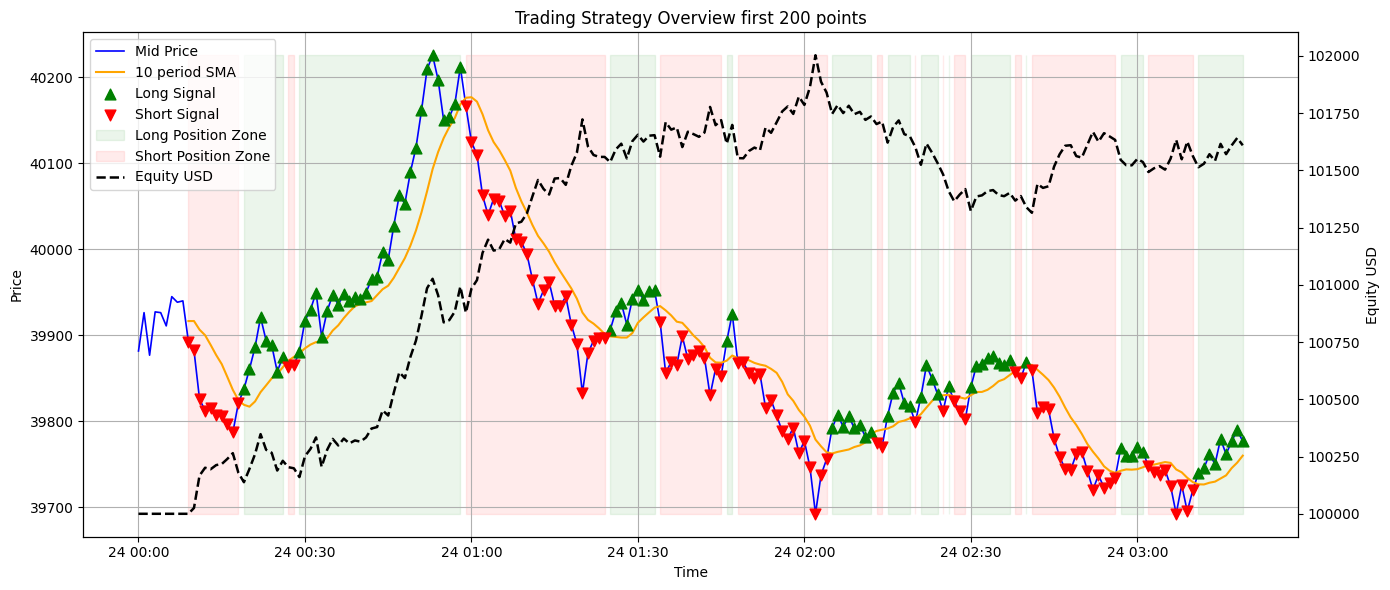

(<Figure size 1400x600 with 2 Axes>,
 <Axes: title={'center': 'Trading Strategy Overview first 200 points'}, xlabel='Time', ylabel='Price'>,
 <Axes: ylabel='Equity USD'>)

In [34]:
plot_strategy_overview(results, n_points=200)

# Task 6

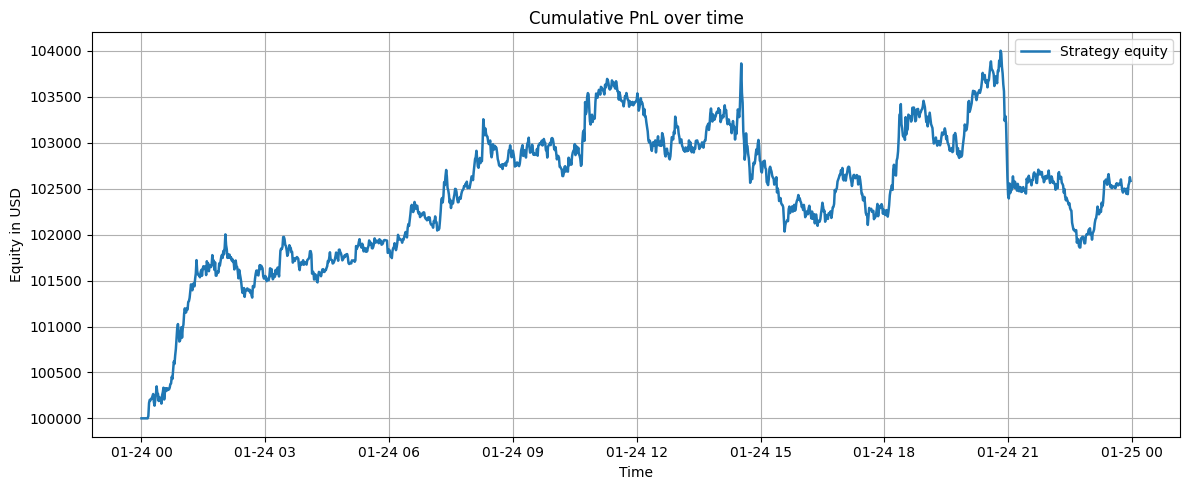

In [35]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df.index, results["equity"], label="Strategy equity", linewidth=1.8)
ax.set_title("Cumulative PnL over time")
ax.set_xlabel("Time")
ax.set_ylabel("Equity in USD")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

## Task 7

In [36]:
transaction_cost_pct = 0.0002  # 0.02% per side
results_with_transaction_cost,metrics = backtest_strategy(df, allow_short_enter=True, transaction_cost_pct=transaction_cost_pct)

Simulation
Initial capital: $100,000.00
Allow short enter: True
Transaction cost per side: 0.0200%
Results
------
Final equity: $93,767.39
Total return: -6.23%
Max drawdown: -8.15%
Number of trades: 225
Sharpe ratio: -46.02985840495116


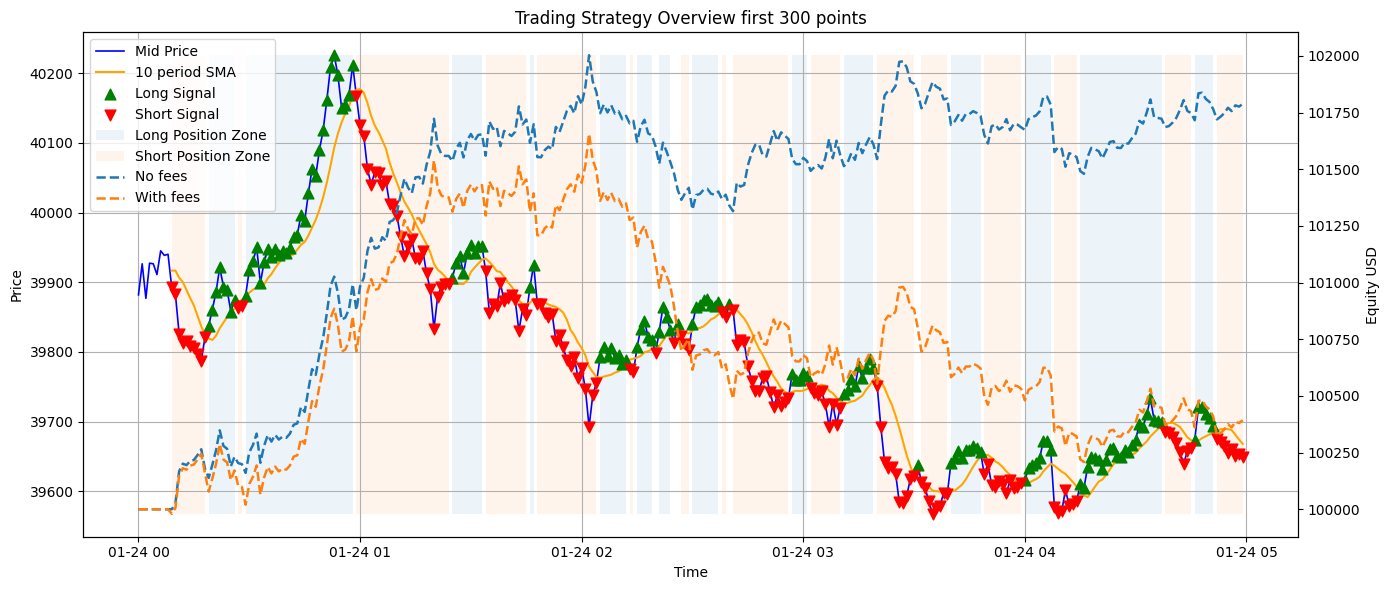

(<Figure size 1400x600 with 2 Axes>,
 <Axes: title={'center': 'Trading Strategy Overview first 300 points'}, xlabel='Time', ylabel='Price'>,
 <Axes: ylabel='Equity USD'>)

In [37]:
plot_strategy_overview_multi(
    results,
    equities={
        "No fees": results["equity"],
        "With fees": results_with_transaction_cost["equity"]
    },
    n_points=300
)

## Task 8

In [38]:
df = pd.read_csv("BTCUSDT_price_data_2024-01-24-2.csv")
df["timestamp"] = df["timestamp"].astype(str).str.replace(r"[^0-9]", "", regex=True)
df["timestamp"] = df["timestamp"].astype(float) / 1000
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
df = df.set_index("datetime")
df.head()

,timestamp,mid_price,volume
datetime,,,
2024-01-24 00:00:00,1.706054e+09,39881.95,439.561
2024-01-24 00:01:00,1.706054e+09,39926.55,776.492
2024-01-24 00:02:00,1.706055e+09,39877.05,339.306
2024-01-24 00:03:00,1.706055e+09,39927.45,246.511
2024-01-24 00:04:00,1.706055e+09,39926.55,423.920


In [42]:
def compute_sma_signal(df, window):
    """Compute SMA and a price vs SMA signal on a copy, then return it."""
    out = df.copy()
    out["sma"] = out["mid_price"].rolling(window=window).mean()
    out["signal"] = 0
    out.loc[out["mid_price"] > out["sma"], "signal"] = 1
    out.loc[out["mid_price"] < out["sma"], "signal"] = -1
    return out

In [43]:
def run_sma_sweep(
    df,
    sma_periods=[5, 10, 20, 50],
    initial_capital=100_000.0,
    transaction_cost_pct=0.0002,
    allow_short_enter=False,
    backtest_func=None,
    price_col="mid_price",
    verbose=False,
):
    """
    Run multiple back tests over a set of SMA periods.
    Assumes `backtest_func` returns (df_result, metrics_dict).

    Returns
    -------
    metrics_df : pd.DataFrame
        One row per SMA period with final equity, total return, drawdown, Sharpe, and trades.
    results_by_period : dict[int, pd.DataFrame]
        Mapping from period to the full result dataframe of that run.
    equities : dict[str, pd.Series]
        Mapping from legend label to equity series, ready for plotting.
    """
    assert backtest_func is not None, "Please pass your backtest function via backtest_func"

    rows = []
    results_by_period = {}
    equities = {}

    for period in sma_periods:
        # period must be integer
        period = int(period)
        # prepare data for this period
        df_period = compute_sma_signal(df, window=period)

        # run back test
        df_res, metrics = backtest_func(
            df_period,
            sma_col="sma",
            price_col=price_col,
            signal_col="signal",
            initial_capital=initial_capital,
            allow_short_enter=allow_short_enter,
            transaction_cost_pct=transaction_cost_pct,
            verbose=verbose
        )

        # collect metrics with safe defaults
        final_equity = metrics.get("final_equity", float(df_res["equity"].iloc[-1]))
        total_return_pct = metrics.get("total_return_pct", None)
        max_drawdown_pct = metrics.get("max_drawdown_pct", None)
        sharpe = metrics.get("sharpe", None)
        num_trades = metrics.get("num_trades", metrics.get("trades", None))

        rows.append({
            "period": int(period),
            "final_equity": final_equity,
            "total_return_pct": total_return_pct,
            "max_drawdown_pct": max_drawdown_pct,
            "sharpe": sharpe,
            "num_trades": num_trades,
        })

        results_by_period[int(period)] = df_res
        equities[f"SMA {period}"] = df_res["equity"]

    metrics_df = pd.DataFrame(rows).set_index("period").sort_values("total_return_pct", ascending=False)
    return metrics_df, results_by_period, equities

In [64]:
sma_periods = np.arange(10,100,10)
metrics_df, results_by_period, equities = simulate.run_sma_sweep(
    df,
    sma_periods=sma_periods,
    initial_capital=100_000.0,
    transaction_cost_pct=0.000,
    allow_short_enter=True,
    backtest_func=backtest_strategy
)

In [65]:
metrics_df

,final_equity,total_return_pct,max_drawdown_pct,sharpe,num_trades
period,,,,,
10,102585.485067,2.585485,-2.060137,21.026623,225
20,101771.632451,1.771632,-1.479785,14.573973,143
30,100734.009615,0.734010,-1.720655,6.214547,130
80,100395.484541,0.395485,-2.672969,3.519377,70
40,100071.627496,0.071627,-1.929877,0.810779,122
70,99989.603282,-0.010397,-2.623164,0.132239,79
50,99791.376227,-0.208624,-2.442526,-1.501112,108
60,99307.476997,-0.692523,-2.176408,-5.553743,87
90,99017.194275,-0.982806,-3.634612,-8.082345,74


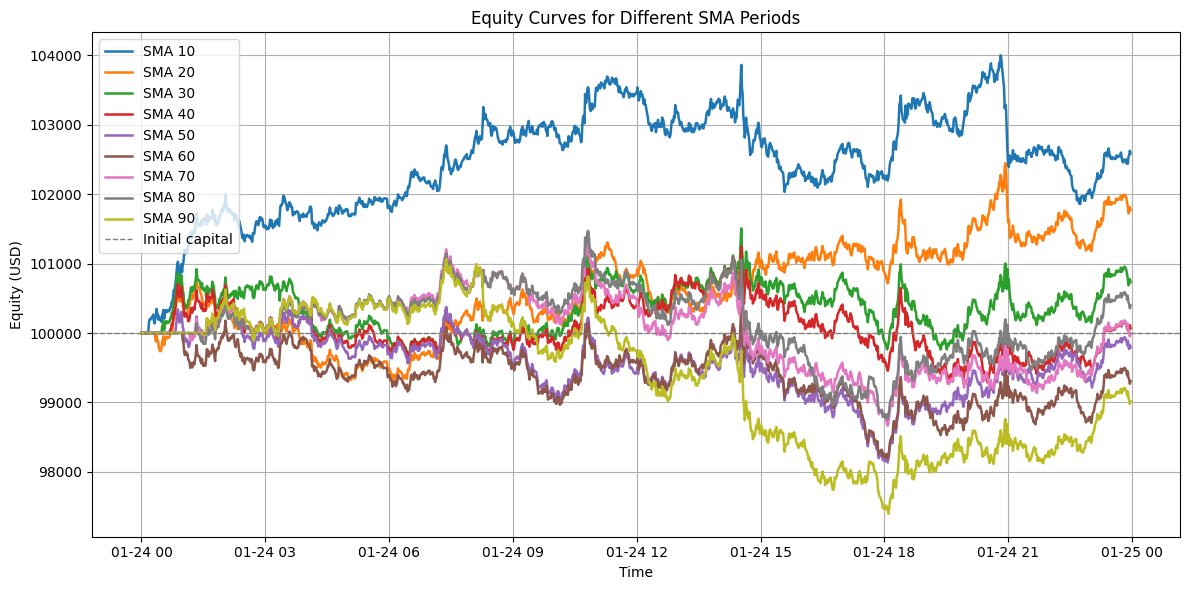

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Equity Curves for Different SMA Periods'}, xlabel='Time', ylabel='Equity (USD)'>)

In [67]:
# simple comparison plot
utils.plot_equity_curves(
    equities=equities,
    n_points=10000,
    title="Equity Curves for Different SMA Periods"
)

In [68]:
sma_periods = np.arange(10,100,10)
metrics_df, results_by_period, equities = simulate.run_sma_sweep(
    df,
    sma_periods=sma_periods,
    initial_capital=100_000.0,
    transaction_cost_pct=0.0002,
    allow_short_enter=True,
    backtest_func=backtest_strategy
)

In [69]:
metrics_df

,final_equity,total_return_pct,max_drawdown_pct,sharpe,num_trades
period,,,,,
80,97640.490470,-2.359510,-4.256443,-18.857262,70
70,96895.893135,-3.104107,-4.558698,-24.737910,79
90,96145.875013,-3.854125,-5.812078,-31.231840,74
20,96127.712692,-3.872287,-4.914424,-29.279813,143
60,95927.002869,-4.072997,-4.767041,-32.356532,87
30,95644.426919,-4.355573,-5.606409,-33.537842,130
50,95587.879563,-4.412120,-5.819701,-34.769721,108
40,95320.383651,-4.679616,-5.884007,-36.435430,122
10,93767.387537,-6.232612,-8.152250,-46.029858,225


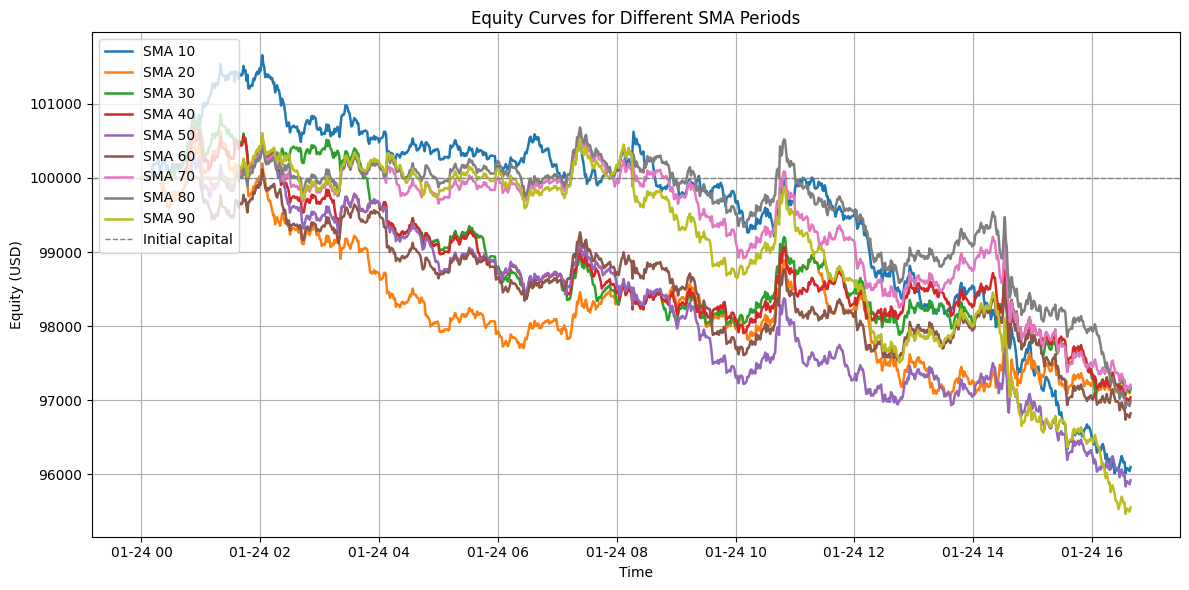

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Equity Curves for Different SMA Periods'}, xlabel='Time', ylabel='Equity (USD)'>)

In [70]:
# simple comparison plot
utils.plot_equity_curves(
    equities=equities,
    n_points=1000,
    title="Equity Curves for Different SMA Periods"
)

# End